In [1]:
import torch, random
import numpy as np
import torch.nn.functional as F
from tqdm.auto import tqdm
from IPython.display import Audio
from matplotlib import pyplot as plt
from diffusers import DiffusionPipeline, AudioPipelineOutput
from torchaudio import transforms as AT
from torchvision import transforms as IT

import torchaudio
import transformers
from transformers import ClapProcessor, ClapModel, AutoProcessor
from torch.optim import AdamW, Adam
from torch.utils.data import DataLoader, Dataset

from diffusers import MusicLDMPipeline


/home/matteoc/miniconda3/envs/speech-meg/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load MusicCAPS

In [23]:
from datasets import load_dataset

ds = load_dataset('google/MusicCaps', split='train')

import subprocess
import os
from pathlib import Path

def download_clip(
    video_identifier,
    output_filename,
    start_time,
    end_time,
    tmp_dir='/tmp/musiccaps/',
    num_attempts=5,
    url_base='https://www.youtube.com/watch?v='
):
    status = False

    command = f"""
        yt-dlp --quiet --no-warnings -x --audio-format wav -f bestaudio -o "{output_filename}" --download-sections "*{start_time}-{end_time}" {url_base}{video_identifier}
    """.strip()

    attempts = 0
    while True:
        try:
            output = subprocess.check_output(command, shell=True,
                                                stderr=subprocess.STDOUT)
        except subprocess.CalledProcessError as err:
            attempts += 1
            if attempts == num_attempts:
                return status, err.output
        else:
            break

    # Check if the video was successfully saved.
    status = os.path.exists(output_filename)
    return status, 'Downloaded'


from datasets import Audio as audiod

samples_to_load = 5521      # How many samples to load
cores = 4                 # How many processes to use for the loading
sampling_rate = 44100     # Sampling rate for the audio, keep in 44100
writer_batch_size = 1000  # How many examples to keep in memory per worker. Reduce if OOM.
data_dir = "/srv/nfs-data/sisko/matteoc/music/music_data_caps" # Where to save the data

# Just select some samples 
ds = ds.select(range(samples_to_load))

# Create directory where data will be saved
data_dir = Path(data_dir)
data_dir.mkdir(exist_ok=True, parents=True)

def process(example):
    outfile_path = str(data_dir / f"{example['ytid']}.wav")
    status = True
    if not os.path.exists(outfile_path):
        status = False
        status, log = download_clip(
            example['ytid'],
            outfile_path,
            example['start_s'],
            example['end_s'],
        )

    example['audio'] = outfile_path
    example['download_status'] = status
    return example


ds = ds.map(
        process,
        num_proc=cores,
        writer_batch_size=writer_batch_size,
        keep_in_memory=False
    ).cast_column('audio', audiod(sampling_rate=sampling_rate))

In [24]:
song_idx = 3799
audio_array = ds[song_idx]["audio"]["array"]
audio_caption = ds[song_idx]["caption"]
sample_rate_dataset = ds[song_idx]["audio"]["sampling_rate"]
print("Audio array shape:", audio_array.shape)
print("Audio caption:", audio_caption)
print("Sample rate:", sample_rate_dataset)
display(Audio(audio_array[0:10*sample_rate_dataset], rate=sample_rate_dataset))

Audio array shape: (880832,)
Audio caption: The low quality recording features a classical song that consists of a brass solo melody played over sustained brass melody and short flute lick. It sounds emotional, joyful and the recording is noisy.
Sample rate: 44100


In [25]:
ds[song_idx]

{'ytid': 'dbBlYyaFKTQ',
 'start_s': 30,
 'end_s': 40,
 'audioset_positive_labels': '/m/01kcd,/m/0319l,/m/05pd6,/m/07c6l,/m/07gql',
 'aspect_list': "['low quality', 'noisy', 'classical', 'flute lick', 'brass solo melody', 'sustained brass melody', 'emotional', 'joyful']",
 'caption': 'The low quality recording features a classical song that consists of a brass solo melody played over sustained brass melody and short flute lick. It sounds emotional, joyful and the recording is noisy.',
 'author_id': 4,
 'is_balanced_subset': False,
 'is_audioset_eval': False,
 'audio': {'path': '/srv/nfs-data/sisko/matteoc/music/music_data_caps/dbBlYyaFKTQ.wav',
  'array': array([-0.00827911, -0.01138475, -0.01273868, ..., -0.01942613,
         -0.01393065,  0.        ]),
  'sampling_rate': 44100},
 'download_status': True}

## Music Bench

In [85]:
from datasets import load_dataset

ds_music_bench = load_dataset("amaai-lab/MusicBench")

Generating test split: 100%|██████████| 800/800 [00:00<00:00, 60154.95 examples/s]


In [107]:
len(ds_music_bench['train'])

52768

In [116]:
ds_music_bench['train'][0]['location']

'data_aug2/-0SdAVK79lg_1.wav'

## Build Dataset

In [ ]:
def pad_or_truncate_audio(audio, max_len_samples):
    """Pads the audio to the max length with zeros or truncates if necessary."""
    audio = torch.tensor(audio).float()
    if len(audio) < max_len_samples:
        padding = max_len_samples - len(audio)
        audio = F.pad(audio, (0, padding), 'constant', 0)
    else:
        audio = audio[:max_len_samples]
    return audio

max_len_sec = 10
# audio_tensor = torch.zeros(samples_to_load, sample_rate_dataset*max_len_sec)
audio_tensor = []
text_tensor = []
for elem in tqdm(range(len(ds))):
    try:
        audio_select = ds[elem]["audio"]["array"]
        text_select = ds[elem]["caption"]
    except FileNotFoundError:
        continue
    audio_padded = pad_or_truncate_audio(audio_select, sample_rate_dataset*max_len_sec)
    # audio_tensor[elem] = audio_padded
    audio_tensor.append(audio_padded)
    text_tensor.append(text_select)
audio_tensor = torch.stack(audio_tensor, dim=0)
text_tensor = torch.stack(text_tensor, dim=0)




In [2]:
text_tensor =  np.load('/srv/nfs-data/sisko/matteoc/music/music_data_caps_capt.npy').tolist()
audio_tensor = torch.load('/srv/nfs-data/sisko/matteoc/music/music_data_caps_audio.pt')

In [3]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

repo_id = "ucsd-reach/musicldm"
musicldm_pipe = MusicLDMPipeline.from_pretrained(repo_id, torch_dtype=torch.float32)
device = "cuda:0" if torch.cuda.is_available() else "cpu"
musicldm_pipe = musicldm_pipe.to(device)

clap_model_id = "laion/larger_clap_music_and_speech"
clap_model = ClapModel.from_pretrained(clap_model_id).to(device)
clap_process = AutoProcessor.from_pretrained(clap_model_id)

Loading pipeline components...: 100%|██████████| 7/7 [00:00<00:00,  7.84it/s]
/home/matteoc/miniconda3/envs/speech-meg/lib/python3.9/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [4]:
from librosa.filters import mel as librosa_mel_fn
import sys
import os
# Add the root directory to the Python path
sys.path.append(os.path.abspath(".."))
from data.audioLDM_pre import *

sampling_rate_ldm = 16000
n_mel_channels = 64
mel_fmin = 0
mel_fmax = 8000
duration = 10.0
filter_length = 1024
hop_length = 160
win_length = 1024 
window = 'hann'
target_length = int(duration * sampling_rate_ldm / hop_length)
pad_wav_start_sample = 0

# resampler = torchaudio.transforms.Resample(orig_freq=44100, new_freq=sampling_rate_ldm)
# audio_res = resampler(audio_tensor[0])

stft = STFT(
    filter_length=filter_length, 
    hop_length=hop_length, 
    win_length=win_length,
    window=window
)




In [5]:
class AudioDataset(Dataset):
    def __init__(self, dataset, captions=None, sample_rate_dataset=44100, new_sr=sampling_rate_ldm):
        self.dataset = dataset
        self.captions = captions
        self.resampler = torchaudio.transforms.Resample(orig_freq=sample_rate_dataset, new_freq=new_sr)
        # vself.resampler_clap = torchaudio.transforms.Resample(orig_freq=sample_rate_dataset, new_freq=48000)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        audio_array = self.dataset[idx]
        audio_res = self.resampler(audio_array)

        if self.captions is not None:
            caption = self.captions[idx]
            return audio_res, caption
         
        else:
            return audio_res
    
    
def get_mel_features(audio):
    magnitude, phase = stft.transform(audio)
    mel_basis = librosa_mel_fn(
                sr=sampling_rate_ldm, n_fft=filter_length, n_mels=n_mel_channels, fmin=mel_fmin, fmax=mel_fmax
            )
    mel_basis = torch.from_numpy(mel_basis).float()
    magnitudes = magnitude.data
    mel_output = torch.matmul(mel_basis, magnitudes)
    mel_output = spectral_normalize(mel_output, torch.log).permute(0,2,1)

    return mel_output
    
    


In [9]:
audio_dataset = AudioDataset(audio_tensor, text_tensor)

train_size = int(0.8 * len(audio_dataset))
val_size = len(audio_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(audio_dataset, [train_size, val_size])

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=4)



In [10]:
for step, batch in (enumerate(val_dataloader)):
    batch_sample = 0
    batch_audio = batch[0]
    print('batch_audio: ', batch_audio.shape)
    batch_text = batch[1]
    real_audio_val = get_mel_features(batch_audio).to(device)
    real_text_val = batch_text[batch_sample]
    real_audio_val = real_audio_val[batch_sample].unsqueeze(0).unsqueeze(0)
    print('real_audio_val: ', real_audio_val.shape)
    print('real_text_raw: ', real_text_val)
    audio_features_val = clap_model.get_audio_features(real_audio_val)
    prompt_embeds_val = musicldm_pipe._encode_prompt(
            real_text_val,
            device,
            num_waveforms_per_prompt=1,
            do_classifier_free_guidance=2.0,
            negative_prompt=None,
            prompt_embeds=None,
            negative_prompt_embeds=None,
        )
    print('prompt_embeds_val: ', prompt_embeds_val.shape)

    # inputs = clap_process(audios=real_audio_raw.float(), return_tensors="pt", sampling_rate=48_000)
    # outputs = clap_model(inputs=inputs['input_features'].to(device)).last_hidden_state
    # print('last_hidden_state: ', outputs.shape)

    with torch.no_grad():
        encoded = musicldm_pipe.vae.encode(real_audio_val)
        latents_val = musicldm_pipe.vae.config.scaling_factor * encoded.latent_dist.sample()
        print('latents_val: ', latents_val.shape)
    with torch.no_grad():
        mel_spectrogram_val = musicldm_pipe.vae.decode(latents_val/musicldm_pipe.vae.config.scaling_factor).sample
        print('mel_spectrogram_val: ', mel_spectrogram_val.shape)

    original_waveform_length_val = int(10.0 * musicldm_pipe.vocoder.config.sampling_rate)
    audio_val = musicldm_pipe.mel_spectrogram_to_waveform(mel_spectrogram_val.to(device=device))
    audio_val = audio_val[:, :original_waveform_length_val]
    output_type = "np"
    if output_type == "np":
        audio_val = audio_val.detach().numpy()
    audio_pipe_val = AudioPipelineOutput(audios=audio_val)
    break

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

batch_audio:  torch.Size([8, 160000])
real_audio_val:  torch.Size([1, 1, 1001, 64])
real_text_raw:  A female singer sings this passionate melody. The song is a medium  tempo with a groovy bass line , steady drumming, keyboard accompaniment, Indian percussion and tambourine accompaniment. The song is playful and romantic. The song is a modern Bollywood pop song with average quality audio.
prompt_embeds_val:  torch.Size([2, 512])
latents_val:  torch.Size([1, 8, 250, 16])
mel_spectrogram_val:  torch.Size([1, 1, 1000, 64])


In [11]:
# True Audio

Audio(audio_pipe_val[0], rate=16000)

## Training

In [12]:
from peft import LoraConfig, LoraModel, get_peft_model, TaskType
os.environ["TOKENIZERS_PARALLELISM"] = "false"


In [13]:
lora = True

if lora:
    named_modules = [(n, type(m)) for n, m in musicldm_pipe.unet.named_modules()]
    target_modules = []
    for n, m in named_modules:
        if m == torch.nn.Linear or m == torch.nn.Conv2d or m == transformers.pytorch_utils.Conv1D:
            target_modules.append(n)
        
    print('tot_modules: ', len(named_modules))
    print('tot_modules: ', len(target_modules))

    # peft_config = LoraConfig(task_type=TaskType.SEQ_2_SEQ_LM, 
    peft_config = LoraConfig(inference_mode=False, 
                            r=32, lora_alpha=64, 
                            lora_dropout=0.1, target_modules=target_modules)
    # unet_lora_config = LoraConfig(
    #     r=128,
    #     lora_alpha=256,
    #     init_lora_weights="gaussian",
    #     target_modules=["to_k", "to_q", "to_v", "to_out.0"],
    # )
    lora_model = get_peft_model(musicldm_pipe.unet, peft_config)

    for param in lora_model.parameters():
        param.requires_grad = False
    for name, param in lora_model.named_parameters():
        if "lora_" in name:
            param.requires_grad = True

    lora_model.print_trainable_parameters()

    model = lora_model

else: 
    model = musicldm_pipe.unet

tot_modules:  688
tot_modules:  284
trainable params: 16,296,448 || all params: 201,333,000 || trainable%: 8.0943


In [14]:
def count_trainable_params(model):
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Trainable params : {trainable_params/1e6} M  over {total_params/1e6}M : {trainable_params/total_params}")
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_trainable_params(model)

Trainable params : 16.296448 M  over 201.333M : 0.08094275652774259


16296448

In [15]:
output_type = "np"
audio_length_in_s = 10.0
num_inference_steps = 50
cross_attention_kwargs = None
guidance_scale = 2.0
do_classifier_free_guidance = guidance_scale > 1.0
callback = None
callback_steps = 1
extra_step_kwargs= {}
extra_step_kwargs["eta"] = 0.0
extra_step_kwargs["generator"] = torch.Generator(device=device).manual_seed(42)

In [16]:
num_epochs = 10  
lr = 1e-4  
grad_accumulation_steps = 2  

optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
# optimizer = torch.optim.AdamW(
#         filter(lambda p: p.requires_grad, musicldm_pipe.unet.parameters()),
#         lr=lr)

train_losses = []
val_losses = []


In [17]:
import wandb 

wandb.login(key='41a4723fac40aff96b88423b6d3e15dd64f87488')
wandb.init()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: matteociferri-1995 (MusicLDMFinetune). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/matteoc/.netrc


In [18]:
def training_step(batch_audio, batch_text, bs):

    batch_mel = get_mel_features(batch_audio).to(device).unsqueeze(1)
    encoded = musicldm_pipe.vae.encode(batch_mel)
    latents_real = musicldm_pipe.vae.config.scaling_factor * encoded.latent_dist.mean
    audio_features = clap_model.get_audio_features(batch_mel)
    text_features = musicldm_pipe._encode_prompt(
        list(batch_text),
        device,
        num_waveforms_per_prompt=1,
        do_classifier_free_guidance=False,
        negative_prompt='',
        prompt_embeds=None,
        negative_prompt_embeds=None,
    )

    # noise = torch.randn(latents_real.shape).to(latents_real.device)
    noise = musicldm_pipe.prepare_latents(
        bs,  #  --> da moltiplicare se num_waveforms_per_prompt > 1
        musicldm_pipe.unet.config.in_channels,
        1000,  # height
        torch.float32,
        torch.device(device),
        generator=torch.Generator(device=device).manual_seed(42),
        latents=None,
    )

    return latents_real, audio_features, text_features, noise

    

In [19]:
# model_ft = musicldm_pipe.unet --> normal mode 

def inference_musicldm(model_ft, latents, features_val):

    do_classifier_free_guidance = guidance_scale  # Modify Here
    musicldm_pipe.scheduler.set_timesteps(num_inference_steps=50, device=device)
    timesteps = musicldm_pipe.scheduler.timesteps
    num_warmup_steps = len(timesteps) - num_inference_steps * musicldm_pipe.scheduler.order
    with musicldm_pipe.progress_bar(total=num_inference_steps) as progress_bar:
        for i, t in enumerate(timesteps):
            # expand the latents if we are doing classifier free guidance
            latent_model_input = torch.cat([latents] * 2) if do_classifier_free_guidance else latents
            latent_model_input = musicldm_pipe.scheduler.scale_model_input(latent_model_input, t)

            # predict the noise residual
            noise_pred_eval = model_ft(
                latent_model_input,
                t,
                encoder_hidden_states=None,
                class_labels=features_val,
                cross_attention_kwargs=cross_attention_kwargs,
                return_dict=False,
            )[0]

            # perform guidance
            if do_classifier_free_guidance:
                noise_pred_uncond, noise_pred_text = noise_pred_eval.chunk(2)
                noise_pred_eval = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

            # compute the previous noisy sample x_t -> x_t-1
            latents = musicldm_pipe.scheduler.step(noise_pred_eval, t, latents, **extra_step_kwargs).prev_sample

            # call the callback, if provided
            if i == len(timesteps) - 1 or ((i + 1) > num_warmup_steps and (i + 1) % musicldm_pipe.scheduler.order == 0):
                progress_bar.update()
                if callback is not None and i % callback_steps == 0:
                    step_idx = i // getattr(musicldm_pipe.scheduler, "order", 1)
                    callback(step_idx, t, latents)
   
    if not output_type == "latent":
        latents = 1 / musicldm_pipe.vae.config.scaling_factor * latents
        print('LATENT HAT MEAN: ', latents.mean())
        print('LATENT HAT STD: ', latents.std()) 
        mel_spectrogram = musicldm_pipe.vae.decode(latents).sample
    
    original_waveform_length = int(audio_length_in_s * musicldm_pipe.vocoder.config.sampling_rate)
    audio_to_save = musicldm_pipe.mel_spectrogram_to_waveform(mel_spectrogram.to(device=device))
    audio_to_save = audio_to_save[:, :original_waveform_length]

    if output_type == "np":
        audio = audio_to_save.detach().numpy()
    audio_pipe = AudioPipelineOutput(audios=audio)

    return audio_pipe
            

  0%|          | 0/271 [00:00<?, ?it/s]/home/matteoc/miniconda3/envs/speech-meg/lib/python3.9/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDIMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDIMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)
100%|██████████| 271/271 [05:10<00:00,  1.15s/it]

Epoch 0 average loss: 0.19387065671466813



100%|██████████| 136/136 [00:41<00:00,  3.27it/s]


LATENT MEAN:  tensor(-0.1874, device='cuda:0', grad_fn=<MeanBackward0>)
LATENT STD:  tensor(0.9588, device='cuda:0', grad_fn=<StdBackward0>)


100%|██████████| 50/50 [00:04<00:00, 11.35it/s]


LATENT HAT MEAN:  tensor(-0.1138, device='cuda:0', grad_fn=<MeanBackward0>)
LATENT HAT STD:  tensor(1.0061, device='cuda:0', grad_fn=<StdBackward0>)


  0%|          | 0/271 [00:00<?, ?it/s]/home/matteoc/miniconda3/envs/speech-meg/lib/python3.9/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDIMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDIMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)
100%|██████████| 271/271 [05:15<00:00,  1.16s/it]

Epoch 1 average loss: 0.18283199370457237



100%|██████████| 136/136 [00:46<00:00,  2.90it/s]


LATENT MEAN:  tensor(-0.1874, device='cuda:0', grad_fn=<MeanBackward0>)
LATENT STD:  tensor(0.9588, device='cuda:0', grad_fn=<StdBackward0>)


100%|██████████| 50/50 [00:03<00:00, 14.25it/s]


LATENT HAT MEAN:  tensor(-0.1196, device='cuda:0', grad_fn=<MeanBackward0>)
LATENT HAT STD:  tensor(1.0009, device='cuda:0', grad_fn=<StdBackward0>)


100%|██████████| 271/271 [05:14<00:00,  1.16s/it]

Epoch 2 average loss: 0.186466457160719



100%|██████████| 136/136 [00:41<00:00,  3.29it/s]


LATENT MEAN:  tensor(-0.1874, device='cuda:0', grad_fn=<MeanBackward0>)
LATENT STD:  tensor(0.9588, device='cuda:0', grad_fn=<StdBackward0>)


100%|██████████| 50/50 [00:03<00:00, 13.90it/s]


LATENT HAT MEAN:  tensor(-0.1239, device='cuda:0', grad_fn=<MeanBackward0>)
LATENT HAT STD:  tensor(1.0149, device='cuda:0', grad_fn=<StdBackward0>)


100%|██████████| 271/271 [05:20<00:00,  1.18s/it]

Epoch 3 average loss: 0.18985751400496795



100%|██████████| 136/136 [00:41<00:00,  3.26it/s]


LATENT MEAN:  tensor(-0.1874, device='cuda:0', grad_fn=<MeanBackward0>)
LATENT STD:  tensor(0.9588, device='cuda:0', grad_fn=<StdBackward0>)


100%|██████████| 50/50 [00:03<00:00, 15.83it/s]


LATENT HAT MEAN:  tensor(-0.1259, device='cuda:0', grad_fn=<MeanBackward0>)
LATENT HAT STD:  tensor(0.9680, device='cuda:0', grad_fn=<StdBackward0>)


100%|██████████| 271/271 [05:13<00:00,  1.16s/it]

Epoch 4 average loss: 0.18686418913947453



100%|██████████| 136/136 [00:42<00:00,  3.20it/s]


LATENT MEAN:  tensor(-0.1874, device='cuda:0', grad_fn=<MeanBackward0>)
LATENT STD:  tensor(0.9588, device='cuda:0', grad_fn=<StdBackward0>)


100%|██████████| 50/50 [00:03<00:00, 15.55it/s]


LATENT HAT MEAN:  tensor(-0.1283, device='cuda:0', grad_fn=<MeanBackward0>)
LATENT HAT STD:  tensor(0.9926, device='cuda:0', grad_fn=<StdBackward0>)


100%|██████████| 271/271 [05:12<00:00,  1.15s/it]

Epoch 5 average loss: 0.1934158052025686



100%|██████████| 136/136 [00:41<00:00,  3.25it/s]


LATENT MEAN:  tensor(-0.1874, device='cuda:0', grad_fn=<MeanBackward0>)
LATENT STD:  tensor(0.9588, device='cuda:0', grad_fn=<StdBackward0>)


100%|██████████| 50/50 [00:03<00:00, 14.23it/s]


LATENT HAT MEAN:  tensor(-0.1027, device='cuda:0', grad_fn=<MeanBackward0>)
LATENT HAT STD:  tensor(0.9925, device='cuda:0', grad_fn=<StdBackward0>)


100%|██████████| 271/271 [05:20<00:00,  1.18s/it]

Epoch 6 average loss: 0.18467424885602668



100%|██████████| 136/136 [00:45<00:00,  2.98it/s]


LATENT MEAN:  tensor(-0.1874, device='cuda:0', grad_fn=<MeanBackward0>)
LATENT STD:  tensor(0.9588, device='cuda:0', grad_fn=<StdBackward0>)


100%|██████████| 50/50 [00:03<00:00, 15.62it/s]


LATENT HAT MEAN:  tensor(-0.0912, device='cuda:0', grad_fn=<MeanBackward0>)
LATENT HAT STD:  tensor(0.9763, device='cuda:0', grad_fn=<StdBackward0>)


100%|██████████| 271/271 [05:20<00:00,  1.18s/it]

Epoch 7 average loss: 0.18516131890490925



100%|██████████| 136/136 [00:45<00:00,  3.01it/s]


LATENT MEAN:  tensor(-0.1874, device='cuda:0', grad_fn=<MeanBackward0>)
LATENT STD:  tensor(0.9588, device='cuda:0', grad_fn=<StdBackward0>)


100%|██████████| 50/50 [00:03<00:00, 15.65it/s]


LATENT HAT MEAN:  tensor(-0.1281, device='cuda:0', grad_fn=<MeanBackward0>)
LATENT HAT STD:  tensor(0.9572, device='cuda:0', grad_fn=<StdBackward0>)


100%|██████████| 271/271 [05:23<00:00,  1.19s/it]

Epoch 8 average loss: 0.18378474875404827



100%|██████████| 136/136 [00:46<00:00,  2.95it/s]


LATENT MEAN:  tensor(-0.1874, device='cuda:0', grad_fn=<MeanBackward0>)
LATENT STD:  tensor(0.9588, device='cuda:0', grad_fn=<StdBackward0>)


100%|██████████| 50/50 [00:03<00:00, 15.36it/s]


LATENT HAT MEAN:  tensor(-0.1425, device='cuda:0', grad_fn=<MeanBackward0>)
LATENT HAT STD:  tensor(0.9581, device='cuda:0', grad_fn=<StdBackward0>)


100%|██████████| 271/271 [05:23<00:00,  1.19s/it]

Epoch 9 average loss: 0.18580222551838058



100%|██████████| 136/136 [00:46<00:00,  2.95it/s]


LATENT MEAN:  tensor(-0.1874, device='cuda:0', grad_fn=<MeanBackward0>)
LATENT STD:  tensor(0.9588, device='cuda:0', grad_fn=<StdBackward0>)


100%|██████████| 50/50 [00:03<00:00, 15.72it/s]


LATENT HAT MEAN:  tensor(-0.1274, device='cuda:0', grad_fn=<MeanBackward0>)
LATENT HAT STD:  tensor(0.9337, device='cuda:0', grad_fn=<StdBackward0>)


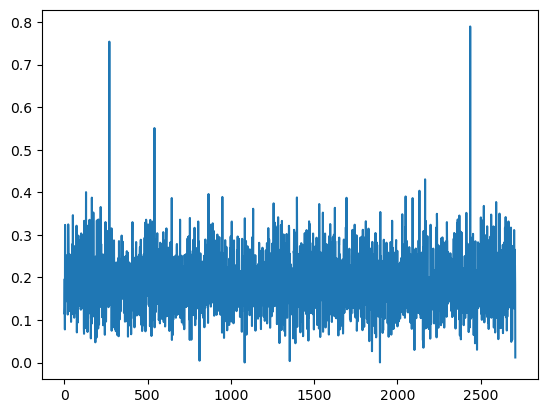

In [20]:
for epoch in range(num_epochs):

    model.train()
    for step, batch_train in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):

        # batch = batch.to(device)
        bs = batch_train[0].shape[0]
        batch_audio = batch_train[0]
        batch_text = batch_train[1]
        latents_real, audio_features, text_features, noise = training_step(batch_audio, batch_text, bs)
        del batch_train
        
        # Sample a random timestep for each image
        timesteps = torch.randint(0, musicldm_pipe.scheduler.num_train_timesteps, (bs,), device=latents_real.device,).long()

        # Add noise to the clean images according to the noise magnitude at each timestep
        # (this is the forward diffusion process) --> we are in the training!
        noisy_latents = musicldm_pipe.scheduler.add_noise(latents_real, noise, timesteps)

        # Get the model prediction for the noise
        noise_pred = model(
            noisy_latents,
            timesteps,
            encoder_hidden_states=None,
            class_labels=text_features,
            cross_attention_kwargs=None,
            return_dict=False,
        )[0]
        
        # Compare the prediction with the actual noise:
        loss = F.mse_loss(
            noise_pred, noise
        )  

        # Store for later plotting
        train_losses.append(loss.item())

        # Update the model parameters with the optimizer based on this loss
        loss.backward()
        wandb.log({'train_loss_step': loss.item()})

        # Gradient accumulation:
        if (step + 1) % grad_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

    print(f"Epoch {epoch} average loss: {sum(train_losses[-len(train_dataloader):])/len(train_dataloader)}")
    wandb.log({'average_train_loss': sum(train_losses[-len(train_dataloader):])/len(train_dataloader)})

    model.eval()
    for step, batch_val in tqdm(enumerate(val_dataloader), total=len(val_dataloader)):

        bs = batch_val[0].shape[0]
        batch_audio = batch_val[0]
        batch_text = batch_val[1]
        if step == 0:
            to_save_audio = batch_audio[0]
            to_save_text = batch_text[0]

        latents_real, audio_features, text_features, noise = training_step(batch_audio, batch_text, bs)
        del batch_val

        # Sample a random timestep for each image
        timesteps = torch.randint(0, musicldm_pipe.scheduler.num_train_timesteps, (bs,), device=latents_real.device,).long()

        # Add noise to the clean images according to the noise magnitude at each timestep
        # (this is the forward diffusion process) --> we are in the training!
        noisy_latents = musicldm_pipe.scheduler.add_noise(latents_real, noise, timesteps)

        # Get the model prediction for the noise
        noise_pred = model(
            noisy_latents,
            timesteps,
            encoder_hidden_states=None,
            class_labels=text_features,
            cross_attention_kwargs=None,
            return_dict=False,
        )[0]
        
        # Compare the prediction with the actual noise:
        loss = F.mse_loss(
            noise_pred, noise
        )  

        # Store for later plotting
        val_losses.append(loss.item())
        wandb.log({'val_loss_step': loss.item()})

    print('LATENT MEAN: ', latents_real[0].mean())
    print('LATENT STD: ', latents_real[0].std()) 
    wandb.log({'average_val_loss': sum(val_losses[-len(val_dataloader):])/len(val_dataloader)})

    audio_reconstr = inference_musicldm(model, noise[0:1], prompt_embeds_val)[0]

    wandb.log({"audio_reconstr": wandb.Audio(audio_reconstr.squeeze(), sample_rate=16000, caption=to_save_text)})
    wandb.log({"audio_real": wandb.Audio(to_save_audio, sample_rate=16000, caption=to_save_text)})

    
# Plot the loss curve:
plt.plot(train_losses)

In [11]:
# musicldm_pipe.unet.save_adapter("/srv/nfs-data/sisko/matteoc/music/music_ldm_train", "lora_adapter")

# clonare modello
# merge and unload
# salvare

import copy

output_dir_lora = "/srv/nfs-data/sisko/matteoc/music/lora_saved_model"

# cloned_pipe = copy.deepcopy(musicldm_pipe)
# unet_lora.merge_and_unload()
musicldm_pipe.save_pretrained(output_dir_lora)

